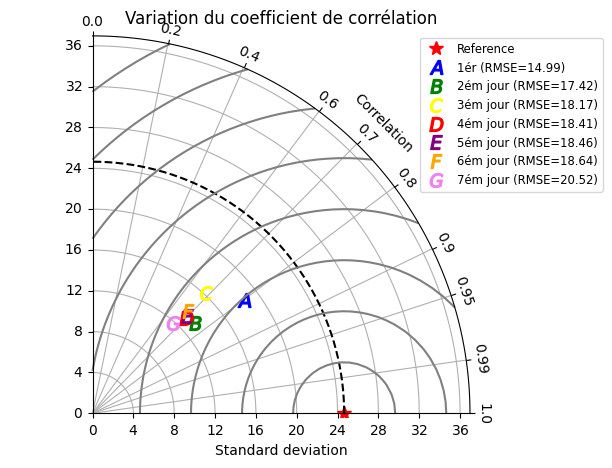

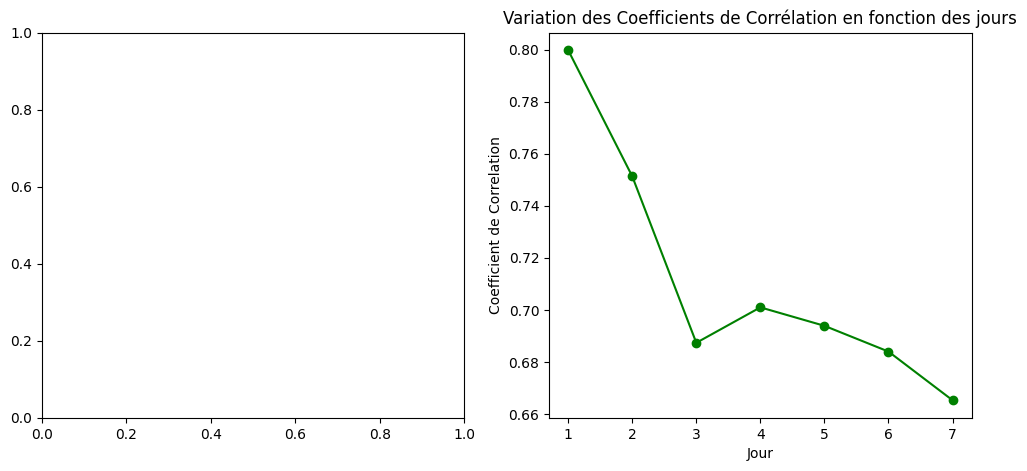

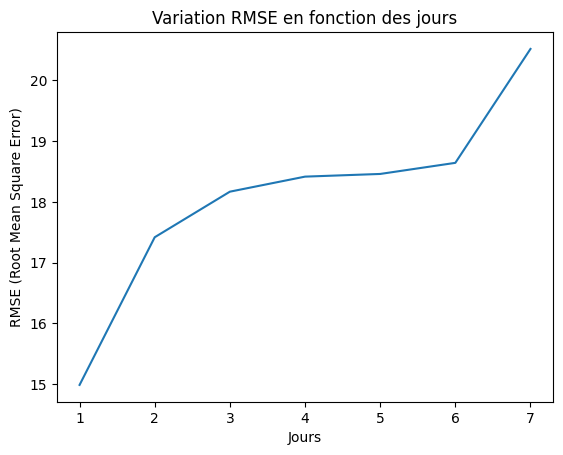

In [3]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.

Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import numpy as np
import matplotlib.pyplot as PLT
import pandas as pd
import matplotlib.pyplot as plt
#from skill_metrics import TaylorDiagram


class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0, 4*NP.pi, 100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x))  # Model 2
    m3 = NP.sin(x-NP.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])

    fig = PLT.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0.5, 1.5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper left')

    return dia


def test2():


    df = pd.read_csv('predictions_et_obs.csv')  #2_1_1
    df1 = pd.read_csv('predictions_p_plus_one.csv')
    df2 = pd.read_csv('predictions_p_plus_two.csv')
    df3 = pd.read_csv('predictions_p_plus_three.csv')
    df4 = pd.read_csv('predictions_p_plus_four.csv')
    df5 = pd.read_csv('predictions_p_plus_five.csv')
    df6 = pd.read_csv('predictions_p_plus_six.csv')
    df7 = pd.read_csv('predictions_p_plus_seven.csv')

# Extraire les colonnes d'observations réelles et de prédictions des modèles
    valeurs_obsA = df['Observé'].values
    valeurs_predites_modele_A = df['Prédit'].values

    valeurs_obsB = df1['Observé (P + 1)'].values
    valeurs_predites_modele_B = df1['Prédit (P + 1)'].values

    valeurs_obsC = df2['Observé (P + 2)'].values
    valeurs_predites_modele_C = df2['Prédit (P + 2)'].values

    valeurs_obsD = df3['Observé (P + 3)'].values
    valeurs_predites_modele_D = df3['Prédit (P + 3)'].values

    valeurs_obsE = df4['Observé (P + 4)'].values
    valeurs_predites_modele_E = df4['Prédit (P + 4)'].values

    valeurs_obsF = df5['Observé (P + 5)'].values
    valeurs_predites_modele_F = df5['Prédit (P + 5)'].values

    valeurs_obsG = df6['Observé (P + 6)'].values
    valeurs_predites_modele_G = df6['Prédit (P + 6)'].values

    valeurs_obsH = df7['Observé (P + 7)'].values
    valeurs_predites_modele_H = df7['Prédit (P + 7)'].values
# ...
    fig = PLT.figure(figsize=(7, 5))
# Créer un diagramme de Taylor
    refstd = np.std(valeurs_obsA)
    dia = TaylorDiagram(refstd, fig=fig, label='Reference', extend=False)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    rmse_modele_A = np.sqrt(np.mean((valeurs_predites_modele_A - valeurs_obsA) ** 2))
    rmse_modele_B = np.sqrt(np.mean((valeurs_predites_modele_B - valeurs_obsB) ** 2))
    rmse_modele_C = np.sqrt(np.mean((valeurs_predites_modele_C - valeurs_obsC) ** 2))
    rmse_modele_D = np.sqrt(np.mean((valeurs_predites_modele_D - valeurs_obsD) ** 2))
    rmse_modele_E = np.sqrt(np.mean((valeurs_predites_modele_E - valeurs_obsE) ** 2))
    rmse_modele_F = np.sqrt(np.mean((valeurs_predites_modele_F - valeurs_obsF) ** 2))
    rmse_modele_G = np.sqrt(np.mean((valeurs_predites_modele_G - valeurs_obsG) ** 2))
    #rmse_modele_H = np.sqrt(np.mean((valeurs_predites_modele_H - valeurs_obsH) ** 2))                                      

# Ajouter les échantillons (modèles) au diagramme
    dia.add_sample(np.std(valeurs_predites_modele_A), np.corrcoef(valeurs_obsA, valeurs_predites_modele_A)[0, 1], marker='$A$', ms=10, ls='', mfc='blue', mec='blue', label=f'1ér (RMSE={rmse_modele_A:.2f})')
    dia.add_sample(np.std(valeurs_predites_modele_B), np.corrcoef(valeurs_obsB, valeurs_predites_modele_B)[0, 1], marker='$B$', ms=10, ls='', mfc='green', mec='green', label=f'2ém jour (RMSE={rmse_modele_B:.2f})')
    dia.add_sample(np.std(valeurs_predites_modele_C), np.corrcoef(valeurs_obsC, valeurs_predites_modele_C)[0, 1], marker='$C$', ms=10, ls='', mfc='yellow', mec='yellow', label=f'3ém jour (RMSE={rmse_modele_C:.2f})')
    dia.add_sample(np.std(valeurs_predites_modele_D), np.corrcoef(valeurs_obsD, valeurs_predites_modele_D)[0, 1], marker='$D$', ms=10, ls='', mfc='red', mec='red', label=f'4ém jour (RMSE={rmse_modele_D:.2f})')
    dia.add_sample(np.std(valeurs_predites_modele_E), np.corrcoef(valeurs_obsE, valeurs_predites_modele_E)[0, 1], marker='$E$', ms=10, ls='', mfc='purple', mec='purple', label=f'5ém jour (RMSE={rmse_modele_E:.2f})')
    dia.add_sample(np.std(valeurs_predites_modele_F), np.corrcoef(valeurs_obsF, valeurs_predites_modele_F)[0, 1], marker='$F$', ms=10, ls='', mfc='orange', mec='orange', label=f'6ém jour (RMSE={rmse_modele_F:.2f})')
    dia.add_sample(np.std(valeurs_predites_modele_G), np.corrcoef(valeurs_obsG, valeurs_predites_modele_G)[0, 1], marker='$G$', ms=10, ls='', mfc='violet', mec='violet', label=f'7ém jour (RMSE={rmse_modele_G:.2f})')
    #dia.add_sample(np.std(valeurs_predites_modele_H), np.corrcoef(valeurs_obsH, valeurs_predites_modele_H)[0, 1], marker='$H$', ms=10, ls='', mfc='gray', mec='gray', label=f'8ém jour (RMSE={rmse_modele_H:.2f})')

# ...

# Ajouter des contours RMS et des grilles
    dia.add_contours(levels=10, colors='0.5')
    dia.add_grid()

# Configurer les axes et la légende
    dia._ax.axis[:].major_ticks.set_tick_out(True)
    plt.legend(dia.samplePoints, [p.get_label() for p in dia.samplePoints], numpoints=1, prop=dict(size='small'), loc='upper right', bbox_to_anchor=(1.35, 1))
    
# Ajouter un titre au diagramme
    plt.title('Variation du coefficient de corrélation')

    plt.savefig('diagramme_taylor.png')

    # Créer un subplot pour le plot RMSE en fonction des jours
    '''ax2 = fig.add_subplot(1, 2, 2)
    jours = np.array([1, 2, 3, 4, 5, 6, 7, 8])  # Numéros de jour
    rmse = np.array([rmse_modele_A, rmse_modele_B, rmse_modele_C, rmse_modele_D, rmse_modele_E, rmse_modele_F, rmse_modele_G, rmse_modele_H])  
    
# Valeurs RMSE
    ax2.plot(jours, rmse, marker='o', linestyle='-', color='blue')
    ax2.set_xlabel('Jour')
    ax2.set_ylabel('RMSE')
    ax2.set_title('RMSE en fonction des jours')

    # Sauvegarder le diagramme de Taylor avec le subplot RMSE
    #plt.tight_layout()
    #plt.savefig('diagramme_taylor.png')

    #PLT.show()'''

    # Plot RMSE Values
    jours = np.array([1, 2, 3, 4, 5, 6, 7])  # Numéros de jour
    rmse = np.array([rmse_modele_A, rmse_modele_B, rmse_modele_C, rmse_modele_D, rmse_modele_E, rmse_modele_F, rmse_modele_G])
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    fig, ax = plt.subplots()
    ax.plot(jours, rmse)
    ax.set_xlabel('Jours')
    ax.set_ylabel('RMSE (Root Mean Square Error)')
    ax.set_title('Variation RMSE en fonction des jours')

    plt.savefig('rmse.png')
    
    # Plot correlation coefficients
    jours = np.array([1, 2, 3, 4, 5, 6, 7])  # Replace with actual days

    correlation_coefficients = [
       np.corrcoef(valeurs_obsA, valeurs_predites_modele_A)[0, 1],
       np.corrcoef(valeurs_obsB, valeurs_predites_modele_B)[0, 1],
       np.corrcoef(valeurs_obsC, valeurs_predites_modele_C)[0, 1],
       np.corrcoef(valeurs_obsD, valeurs_predites_modele_D)[0, 1],
       np.corrcoef(valeurs_obsE, valeurs_predites_modele_E)[0, 1],
       np.corrcoef(valeurs_obsF, valeurs_predites_modele_F)[0, 1],
       np.corrcoef(valeurs_obsG, valeurs_predites_modele_G)[0, 1],
       #np.corrcoef(valeurs_obsH, valeurs_predites_modele_H)[0, 1]
       ]
    
    ax2.plot(jours, correlation_coefficients, marker='o', linestyle='-', color='green')
    ax2.set_xlabel('Jour')
    ax2.set_ylabel('Coefficient de Correlation')
    ax2.set_title('Variation des Coefficients de Corrélation en fonction des jours')
    plt.savefig('correlation_plot.png')

    
    plt.show()
    return dia

if __name__ == '__main__':

    #dia = test1()
    dia = test2()

    #plt.savefig('diagramme_taylor.png')

    PLT.show()








